In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [3]:
###

# import shutil

data_dir = './trainset/'
val_dir = './valset'
    
# for fname in os.listdir(data_dir):
#     os.makedirs(os.path.join(val_dir, fname))
#     i = 0
#     for img in os.listdir(os.path.join(data_dir, fname)):
#         if i%5 == 0:
#             source = os.path.join(data_dir, fname, img)
#             dest = os.path.join(val_dir, fname, img)
#             shutil.move(source, dest)
#         i += 1

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(200),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(20),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.25])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.25])
    ])
}

In [5]:
image_datasets = {'train': datasets.ImageFolder(data_dir, data_transforms['train']),
                  'val': datasets.ImageFolder(val_dir, data_transforms['val'])
                 }
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1200
    Root location: ./trainset/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(200, 200), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=(-20, 20))
               ToTensor()
               Normalize(mean=[0.5], std=[0.25])
           )

In [7]:
classes

['nothing', 'ok', 'palm', 'peace', 'punch']

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # self.conv3 = nn.Conv2d(32, 128, 3)
        # self.conv4 = nn.Conv2d(128, 3, 3)
        self.fc1 = nn.Linear(64*98*98, 128)
        # self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(128, 5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))
        # x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64*98*98)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    val_losses = []
    val_acc = []
    losses = []
    acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(inputs.size(), outputs.size(), labels.size())
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    data = {}
    data['epochs'] = range(num_epochs)
    data['val_loss'] = val_losses
    data['loss'] = losses
    data['val_acc'] = val_acc
    data['acc'] = acc
    
    model.load_state_dict(best_model_wts)
    return model, data

In [16]:
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=614656, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)


In [17]:
list(net.parameters())[0].size()

torch.Size([32, 1, 3, 3])

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
best_model, data = train_model(net, criterion, optimizer, scheduler, 
                         num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6966 Acc: 0.1967
val Loss: 1.6137 Acc: 0.2000

Epoch 1/24
----------
train Loss: 1.5655 Acc: 0.3000
val Loss: 1.5614 Acc: 0.3000

Epoch 2/24
----------
train Loss: 1.5368 Acc: 0.3075
val Loss: 1.6168 Acc: 0.2000

Epoch 3/24
----------
train Loss: 1.5964 Acc: 0.2733
val Loss: 1.5476 Acc: 0.2767

Epoch 4/24
----------
train Loss: 1.4877 Acc: 0.4283
val Loss: 1.4300 Acc: 0.5833

Epoch 5/24
----------
train Loss: 1.4620 Acc: 0.4483
val Loss: 1.4093 Acc: 0.5267

Epoch 6/24
----------
train Loss: 1.4433 Acc: 0.4808
val Loss: 1.3958 Acc: 0.5167

Epoch 7/24
----------
train Loss: 1.4290 Acc: 0.4817
val Loss: 1.3708 Acc: 0.5667

Epoch 8/24
----------
train Loss: 1.4121 Acc: 0.5083
val Loss: 1.3586 Acc: 0.6167

Epoch 9/24
----------
train Loss: 1.4102 Acc: 0.5150
val Loss: 1.3525 Acc: 0.6500

Epoch 10/24
----------
train Loss: 1.4218 Acc: 0.5058
val Loss: 1.3538 Acc: 0.6433

Epoch 11/24
----------
train Loss: 1.4208 Acc: 0.4950
val Loss: 1.3546 Acc: 0.6300

Ep

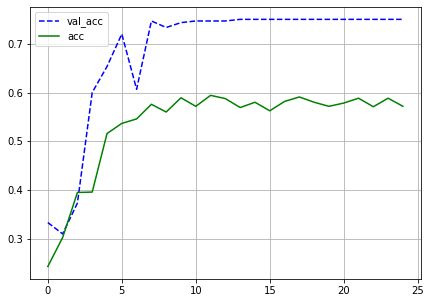

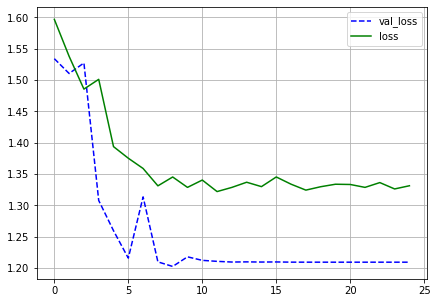

In [71]:
# model, data = best_model
# data['epochs'] = range(25)

plt.figure(1,figsize=(7,5))
plt.plot(data['epochs'], data['val_acc'], 'b--', label='val_acc')
plt.plot(data['epochs'], data['acc'], 'g-', label='acc')
plt.grid(True)
plt.legend()

plt.figure(2,figsize=(7,5))
plt.plot(data['epochs'], data['val_loss'], 'b--', label='val_loss')
plt.plot(data['epochs'], data['loss'], 'g-', label='loss')
plt.grid(True)
plt.legend()

plt.show()

In [72]:
torch.save(best_model.state_dict(), 'optimal_params.pt', override=True)

In [63]:
import json
import cv2 as cv

jsonarray = {}

def update(plot):
    global jsonarray
    h, y, w = 450, 30, 45
    font = cv.FONT_HERSHEY_COMPLEX
    
    for items in jsonarray:
        mul = (jsonarray[items])/100
        cv.line(plot, (0,y), (int(h*mul), y), (255,0,0), w)
        cv.putText(plot, items, (0,y+5), font, 0.7, (0,255,0), 2,1)
        y += w+30
        
    return plot

In [64]:
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def loadCNN():
    model = Net()
    model.load_state_dict(torch.load('optimal_params.pt'))
    return model

def guessGesture(model, img):
    global jsonarray, classes
    
    image = np.array(img)
    image = torch.from_numpy(image).to(device)
    rimage = torch.nn.init.normal_(image, mean=0.5, std=0.25)
    rimage = torch.reshape(rimage, (1, 1, 200, -1))
    
    model.to(device)
    model.eval()
    
    preds = model(rimage)[0]
    
    d = {}
    i = 0 
    for items in classes:
        d[items] = preds[i]*100
        i += 1
        
    _, pred = torch.max(preds, 1)
    
    if d[pred] > 60.0:
        jsonarray = d
        
        return classes.index(pred)
    else:
        return 0
    
    

(200, 200)
torch.float64


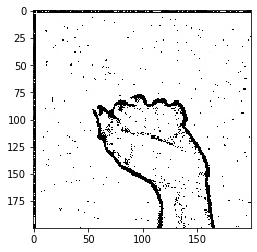

In [91]:
import cv2 as cv

img = cv.imread('./trainset/punch/punch100.jpg', 0)
print(img.shape)
img = img - img.mean()
img /= img.std()

img = (img + 0.5)*0.25

image = img.reshape(1, 1, 200, 200)
rimage = torch.from_numpy(image)
print(rimage.dtype)
plt.imshow(image[0, 0, :, :], cmap='gray')

In [103]:
from PIL import Image
img = cv.imread('./trainset/punch/punch100.jpg', 0)

tfms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.25])
    ])

rimage = tfms(Image.fromarray(img)).to(device)
rimage = torch.reshape(rimage, (1, 1, 200, 200))
best_model.eval()
preds = best_model(rimage)
preds

tensor([[1.3623e-04, 2.6795e-03, 3.3458e-06, 6.9239e-01, 3.0479e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)